In [1]:
%matplotlib inline

In [2]:
import numpy as np
import cv2
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
image_path = './data/chongqing1_round1_train1_20191223/images/'
box_image_path = './data/box_image/'

In [4]:
def annoParse(path):
    """
    Parse the annotation file
    Args:
        path: file path to the annotation file
    Return:
        LUT: a pandas dataframe, unifying all information into a Look Up Table
        categories: a dictionary mapping category id to category name
    """
    with open(path) as fh:
        annotation = json.load(fh)
    # the annotation file has the following keys:
    # info: empty field
    # images: specifies image name, image id, height and width
    # license: empty field
    # categories: types of defects
    # annotations:

    # id-name pairs; id-dimension pairs
    id_name = {}
    id_dimension = {}
    for i in annotation['images']:
        id_name[i['id']] = i['file_name']
        id_dimension[i['id']] = (i['height'], i['width'])
    # id-category pairs; id-bbox pairs
    id_category = {}
    id_bbox = {}
    for i in annotation['annotations']:
        if i['image_id'] in id_category.keys():
            id_category[i['image_id']] = id_category[i['image_id']] + [i['category_id']]
        else:
            id_category[i['image_id']] = [i['category_id']]
        if i['image_id'] in id_bbox.keys():
            id_bbox[i['image_id']] = id_bbox[i['image_id']] + [i['bbox']]
        else:
            id_bbox[i['image_id']] = [i['bbox']]
    # merge information
    LUT = pd.DataFrame()
    LUT['id'] = sorted(id_name.keys())
    LUT['file_name'] = [id_name[x] for x in LUT['id']]
    LUT['height'] = [id_dimension[x][0] for x in LUT['id']]
    LUT['width'] = [id_dimension[x][1] for x in LUT['id']]
    LUT['category'] = [id_category[x] for x in LUT['id']]
    LUT['bbox'] = [id_bbox[x] for x in LUT['id']]
    #category mapping
    categories = {}
    for i in annotation['categories']:
        categories[i['id']] = i['name']
    return LUT, categories

In [5]:
tabb, cate = annoParse('./data/chongqing1_round1_train1_20191223/annotations.json')

In [10]:
print(cate)
print(type(tabb.loc[0]['category'][0]))
tabb.loc[:5]

{1: '瓶盖破损', 9: '喷码正常', 5: '瓶盖断点', 3: '瓶盖坏边', 4: '瓶盖打旋', 0: '背景', 2: '瓶盖变形', 8: '标贴气泡', 6: '标贴歪斜', 10: '喷码异常', 7: '标贴起皱'}
<class 'int'>


,id,file_name,height,width,category,bbox
0,1,img_0017151.jpg,492,658,[2],"[[165.14, 53.71, 39.860000000000014, 63.29]]"
1,2,img_0001675.jpg,492,658,[5],"[[465.71, 314.86, 13.580000000000041, 15.27999..."
2,3,img_0020680.jpg,492,658,"[2, 2]","[[364.57, 47.43, 128.43, 35.86000000000001], [..."
3,4,img_0015046.jpg,492,658,"[9, 2]","[[149.14, 238.29, 147.29000000000002, 40.41999..."
4,5,img_0004341.jpg,492,658,[2],"[[176.57, 48.57, 62.140000000000015, 48.43]]"
5,6,img_0006084.jpg,492,658,[0],"[[7.43, 9.71, 20.43, 19.29]]"


In [20]:
for index, row in tabb.iterrows():
    if index > 7:
        break
    print(row)
    for i, box in enumerate(row['bbox']):
        print("===="+str(type(row['category'])))

id                                                      1
file_name                                 img_0017151.jpg
height                                                492
width                                                 658
category                                              [2]
bbox         [[165.14, 53.71, 39.860000000000014, 63.29]]
Name: 0, dtype: object
====<class 'list'>
id                                                           2
file_name                                      img_0001675.jpg
height                                                     492
width                                                      658
category                                                   [5]
bbox         [[465.71, 314.86, 13.580000000000041, 15.27999...
Name: 1, dtype: object
====<class 'list'>
id                                                           3
file_name                                      img_0020680.jpg
height                                                     492
w

In [21]:
bb = [1,2,4,4,5,6,45,3,2,4]
bb.index(4)

2

In [24]:
def drowBbox(folderPath, annFile, outputPath):
    """
    Drow the annotation boxes.
    Args:
        folderPath: string, file path to the images path.
        annFile: string, annotation file.
        outputPath: string, output images path.
    Return:
        operation function but return last image with numpy style.
    """
    count = 0
    LUT, categories = annoParse(annFile)
    font = cv2.FONT_HERSHEY_TRIPLEX
    for index, row in LUT.iterrows():
        #change the condition according to your situation
        #this filter non-bottle cap images
#         if index > 5:
#             break
        if row['height'] > 1000:
            continue
        npimg = cv2.imread(folderPath+ row['file_name'])
        orgimg = npimg.copy()
        for i, box in enumerate(row['bbox']):
            boxedimg = npimg.copy()
            x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            cv2.rectangle(boxedimg, (x,y), (x+w, y+h), (0,255,0), 1)
            cv2.putText(boxedimg, str(row['category'][i]), (x+w, y+h), font, 1, (255,0,255), 2)
            boxedimg = np.hstack((orgimg,boxedimg))
            cv2.imwrite(outputPath+'%d/'%row['category'][i] +row['file_name']+str(i)+'.jpg', boxedimg)
            count += 1
    print(count)
    return npimg

5922


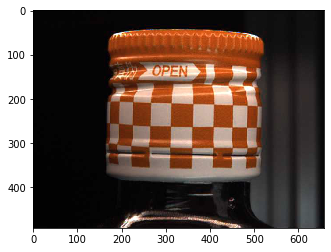

In [25]:
images_path = './data/chongqing1_round1_train1_20191223/images/'
box_images_path = './data/box_image_'
annFile = './data/chongqing1_round1_train1_20191223/annotations.json'
npimg = drowBbox(images_path, annFile, box_images_path)
plt.imshow(npimg)
plt.show()